In [1]:
import warnings
import sys
sys.path.append('../')
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
from tabulate import tabulate
from texttable import Texttable

import latextable
from PrepareData import read_json, make_folder

In [3]:
def flip_label(x):
    if x.iloc[0] == 0:
        return int(1-x.iloc[1])
    else:
        return x.iloc[1]
def flip_label_ma(x):
    if x.iloc[0] == 1:
        return int(1-x.iloc[1])
    else:
        return x.iloc[1]

In [4]:
def draw_scatter_plot(df, output_name_with_path):
    fig, ax = plt.subplots(1, figsize=(8, 6), dpi=220)
    groups = [1, 1, 0, 0]
    labels = [0, 1, 0, 1]
    markers = ['^', 'o', '^', 'o']
    colors = ['#0C2340', '#0C2340', '#F15A22', '#F15A22']
    legends = ['majority + negative', 'majority + positive', 'minority + negative', 'minority + positive']

    for group_i, label_i, marker_i, color_i in zip(groups, labels, markers, colors):
        cur_df = df.query('A=={} and Y=={}'.format(group_i, label_i))

        plt.scatter(cur_df['X1'], cur_df['X2'], c=color_i, marker=marker_i, edgecolors=color_i, s=5, label='')
    plt.savefig(output_name_with_path, bbox_inches="tight") 
    print('Scatter plot is saved at ', output_name_with_path)
#     plt.close()

           X1    X2  Y_prob
A   Y                      
0.0 0.0   892   892     892
    1.0  1108  1108    1108
1.0 0.0  4996  4996    4996
    1.0  3004  3004    3004
syn 1 sigma0.020
Scatter plot is saved at  /Users/keyang/Projects/PubRepo/ConFair/intermediate/plots/syn/sigma0.020.png


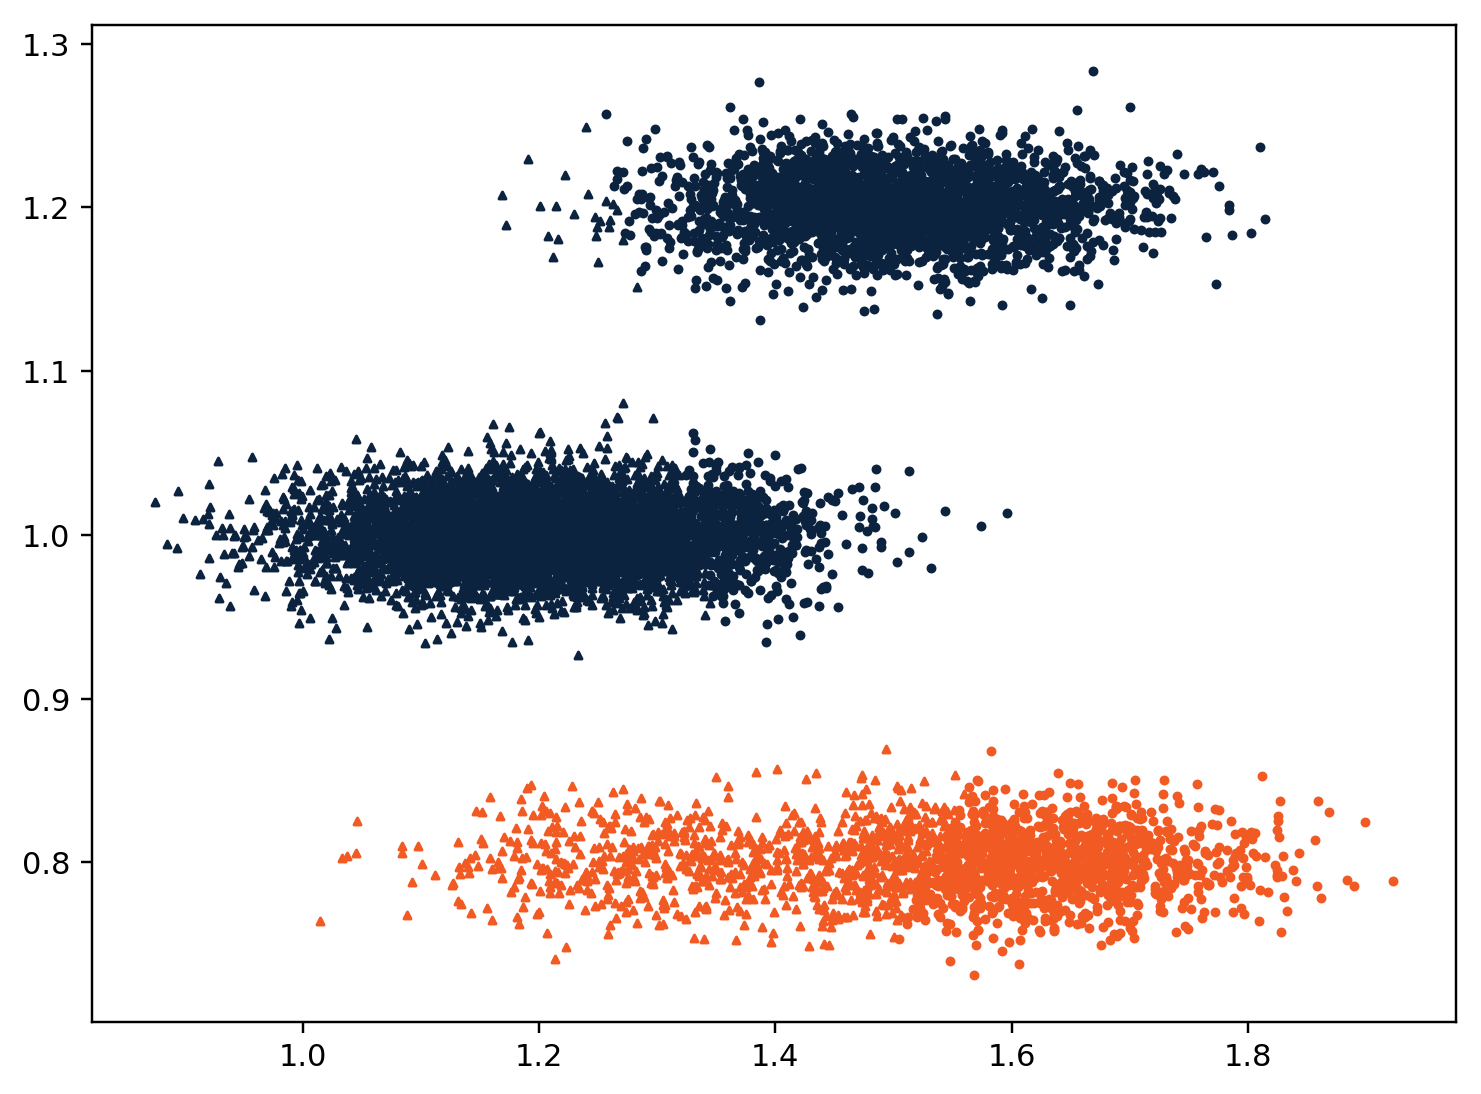

In [5]:
# generate synthetic data
seeds = [1, 12345, 6, 2211, 15]

repo_dir = sys.path[0].replace('notebooks', '')
data_path= repo_dir+ 'data/processed/'
plot_path = repo_dir + 'intermediate/plots/syn/'

make_folder(plot_path)
x1_centers = [1.2, 1.5, 1.3, 1.6]

x1_std = [0.1, 0.1, 0.1, 0.1]

default_sigma = 0.02

x2_centers = [1, 1.2, 0.8, 0.8]

weights_x1 = [-0.6, -0.6, 0.6, 0.6]
weights_x2 = [-0.2, -0.2, -0.4, -0.4]

conds = [-1, -1, 0.6, 0.6]
sizes = [5500, 2500, 500, 1500]

groups = [1, 1, 0, 0]
labels = [0, 1, 0, 1]


for idx, seed in enumerate(seeds[:1]):
    np.random.seed(seed)
    cur_sigma_x2 = default_sigma / (idx+1)
    
    sample_df = pd.DataFrame(columns=['A', 'X1', 'X2', 'Y_prob', 'Y'])
    
    for mu_x1, sigma_x1, mu_x2, weight_x1, weight_x2, cond_i, group_i, size_i in zip(x1_centers, x1_std, x2_centers, weights_x1, weights_x2, conds, groups, sizes):
        cur_x1_values = np.random.normal(mu_x1, sigma_x1, size_i)
        cur_x2_values = np.random.normal(mu_x2, cur_sigma_x2, size_i)
        
        for x1_i, x2_i in zip(cur_x1_values, cur_x2_values):
            y_i = weight_x1*x1_i + weight_x2* x2_i

            if cond_i > 0:
                y_int_i = int(y_i < cond_i)
            else:
                y_int_i = int(y_i > cond_i)
            sample_df.loc[sample_df.shape[0]] = [group_i, x1_i, x2_i, y_i, y_int_i]
    
    # flipping the positive and negative for minority group A=0
    sample_df['Y'] = sample_df[['A', 'Y']].apply(lambda x: flip_label(x), axis=1)
    # flipping the positive and negative for majority group A=1 so that the unfairness against A=0 at the begining, DI<0.8
    sample_df['Y'] = sample_df[['A', 'Y']].apply(lambda x: flip_label_ma(x), axis=1)
    
    print(sample_df.groupby(by=['A','Y']).count())
    sample_df = sample_df.drop(columns=['Y_prob'])
    sample_df.to_csv('{}syn{}.csv'.format(data_path, seed), index=False)
    plot_name = plot_path + 'sigma{:.3f}.png'.format(cur_sigma_x2)
    
    print('syn', idx+1, 'sigma{:.3f}'.format(cur_sigma_x2))
    draw_scatter_plot(sample_df, plot_name)